# AMLD-2021-Sketchy: Training Correction

Purpose: This notebook provides a walk through the process of retrieving photos of the same class as a hand-drawn sketch with the model proposed in [Doodle to Search: Practical Zero-Shot Sketch-based Image Retrieval](http://dagapp.cvc.uab.es/doodle2search/CVPR2019.pdf). 
Complementary information and studies on the model can be found in [here](http://dagapp.cvc.uab.es/doodle2search/CVPR2019_Supplementery.pdf).

Contrarily to the paper above, we perform here a non-zero shot inference, which means that the classes in training, validation and testing are the same (only sketches and images are different). Moreover, we did not implement the semantic loss. Further explanation are provided in the model description part.

In [1]:
# Loads the autoreload package into ipython kernel and set it to automatically reload modules
# when they change
%load_ext autoreload
%autoreload 2

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    
    folder_path = '/content/drive/MyDrive/AMLD data sketchy/'
    CHECKPOINT_PATH = folder_path + 'checkpoint.pth'
    DATA_PATH =  folder_path + 'QuickdrawSubset'

    print('Import the code and install dependencies...')
    !git clone https://github.com/VisiumCH/AMLD-2021-Sketchy.git AMLD-2021-Sketchy
    %cd AMLD-2021-Sketchy/
    !git checkout workshop_notebook
    !pip install -e .
    
else:
    CHECKPOINT_PATH = "/io/models/quickdraw_training/checkpoint.pth"
    DATA_PATH =  "/io/data/raw/Quickdraw"

%pwd

'/home/pauline.maury/AMLD-2021-Sketchy/notebooks/workshop'

## Package Import

In [17]:
# Python imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as vision_models
from torch.utils.data import DataLoader
from torchvision import transforms

# Codebase imports
from src.data.default_dataset import DefaultDataset
from src.data.utils import default_image_loader, get_class_dict, dataset_split
from src.models.loss import GradReverse
from src.models.utils import load_checkpoint

## Model description

### Quick overview

The sketch-based photo retrieval task aims to return photos that are in the same class as sketches drawn by hand. Therefore, two encoders are trained: one for photos and one for sketches. Each encoder maps its input (photo or sketch) to an embedding space E. Then, the embeddings are ranked by similarity based on their euclidean distance in the embedding space and the most similar photos to the sketch  are retrieved.

![img](https://drive.google.com/uc?export=view&id=1UP6VT5BvKvW_ur2NzK1DTPQ0srkf2uFH)
<center> Figure 1: Sketch and Images Embeddings distance </center>

In the figure 1, the sketch is an elephant, image 1 is also an elephant and image 2 is a mountain. The image encoder computes the embeddings $E_{i1}$ and $E_{i2}$ from the image 1 and image 2 respectively. The sketch encoder computes the embedding $E_s$.

In the next steps, the **sketch $E_s$ is the anchor**, **$E_{i1}$ is the positive sample** as it belongs to the same class and **$E_{i2}$ is the negative sample** as it belongs to another class.

As $E_{i1}$ and $E_s$ belong to the same class (elephant) and $E_{i2}$ belongs to another class (mountain), the encoders should compute the embeddings of $E_{i1}$ and $E_s$ 'close' to each other and far from $E_{i2}$.

When $E_s$ is drawn, $E_{i1}$ is closer to it than $E_{i2}$ so we retrieve $E_{i1}$.

## Constants

In [3]:
BATCH_SIZE = 10
TRAINING_SPLIT = 0.8
VALID_SPLIT = 0.1
EMBEDDING_SIZE = 256
TRIPLET_MARGIN = 1

## The Data

We first visualise some random data triplets from the dataset with one sketch, positive image (same class as the sketch) and one negative images (different class than the sketch) as they would typically be fed to the network during training.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
# Get dataset classes
dict_class_to_id = get_class_dict(DATA_PATH)

In [6]:
# Get train and test data
train_data, _, _ = dataset_split(DATA_PATH, TRAINING_SPLIT, VALID_SPLIT)
train_data = DefaultDataset(
    mode="train", 
    data=train_data, 
    dataset_folder=DATA_PATH, 
    dicts_class=dict_class_to_id, 
    transform=transform
)

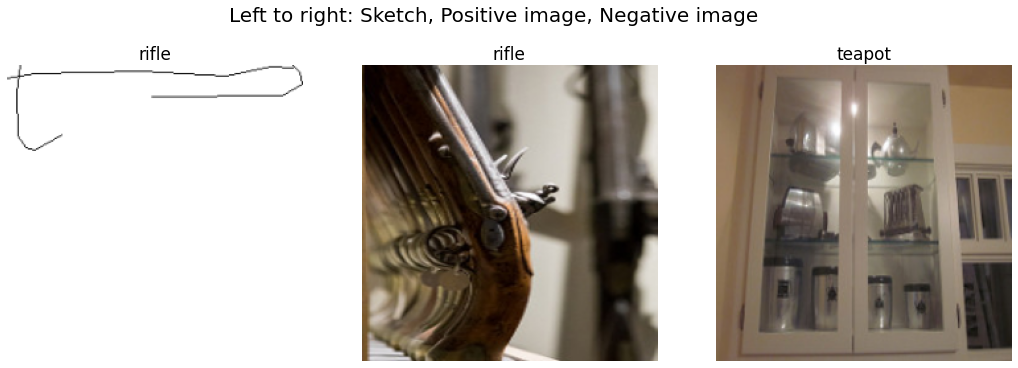

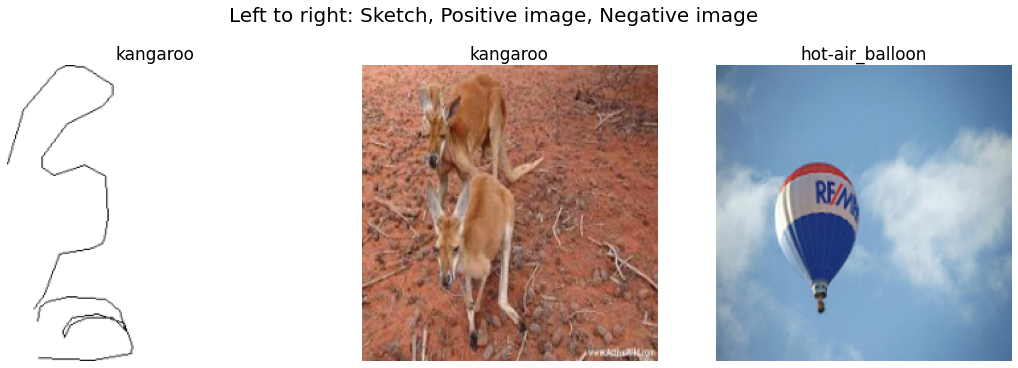

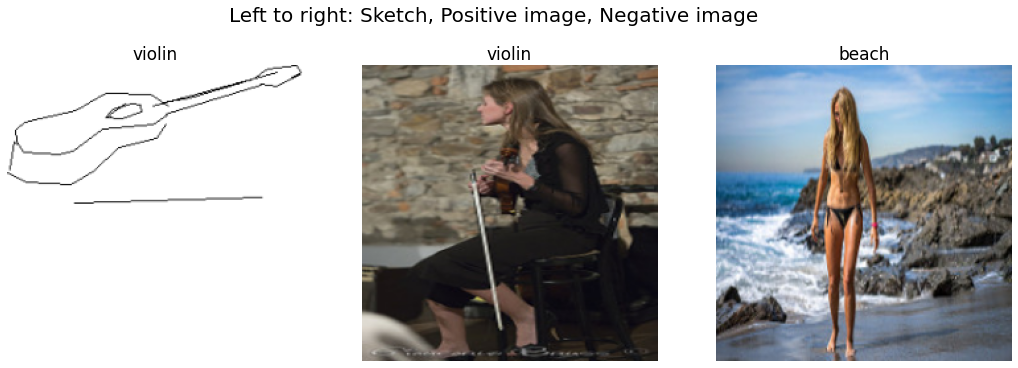

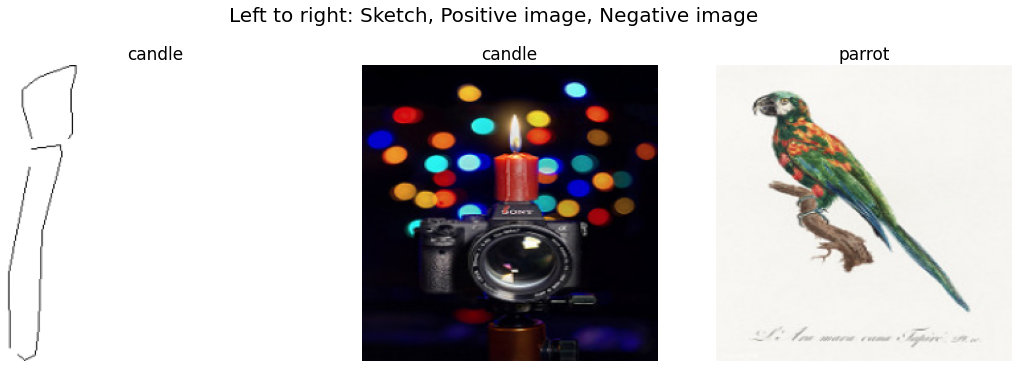

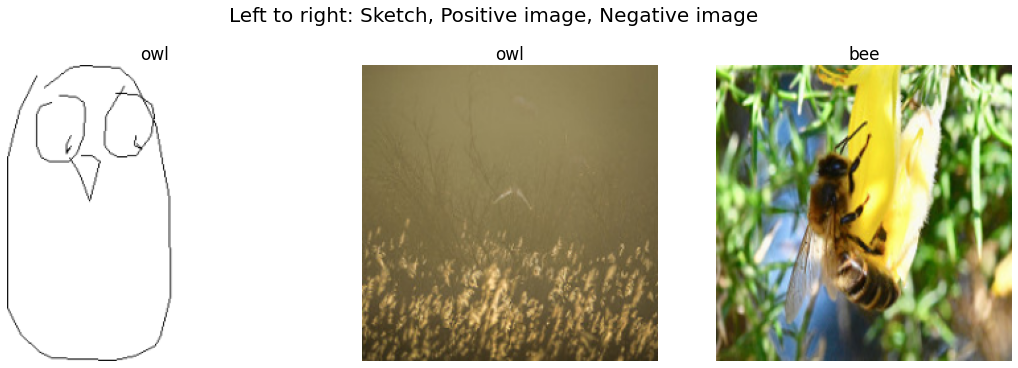

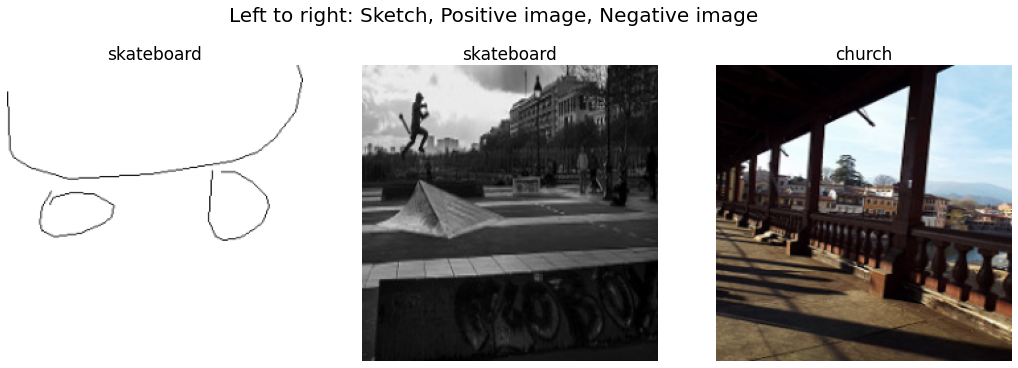

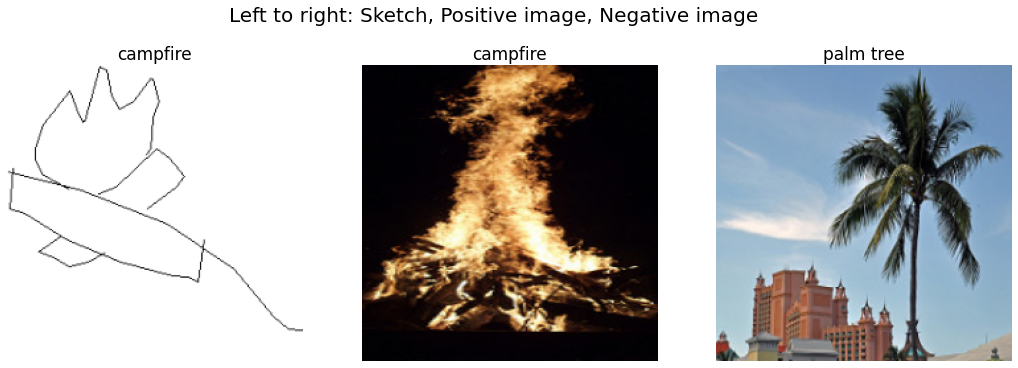

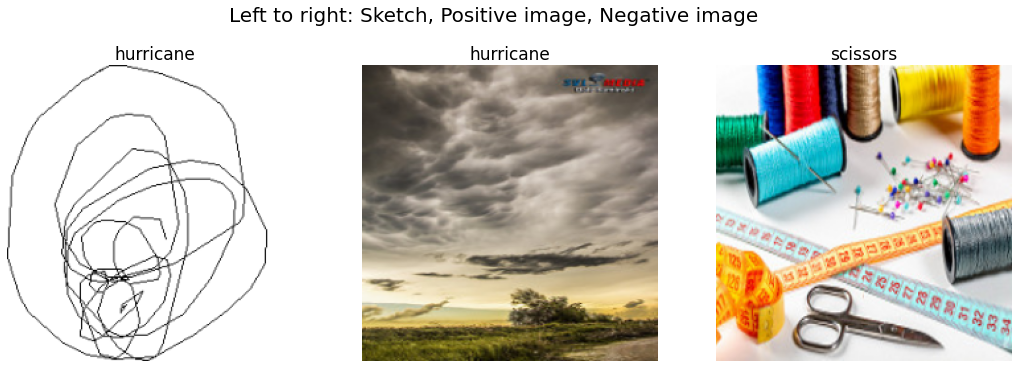

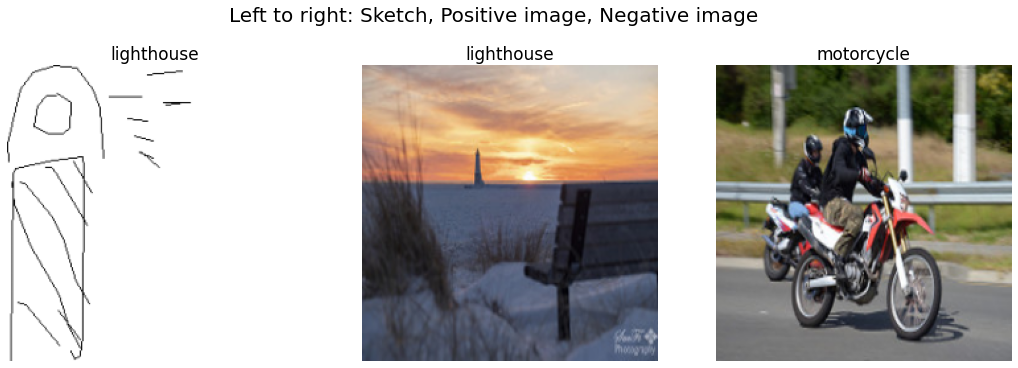

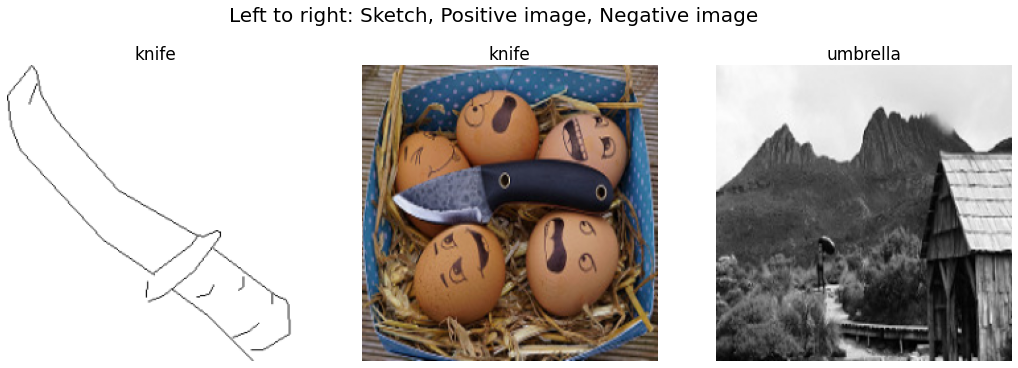

In [7]:
# Let's now load and visualize some training data
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# We will work on a single batch
sketchs, positive_images, negative_images, positive_labels, negative_labels = next(iter(train_loader))
positive_labels, negative_labels = positive_labels.numpy(), negative_labels.numpy()

# Reverse dict to go from id to class
dict_id_to_class = {v:k for k,v in dict_class_to_id.items()}

for i in range(BATCH_SIZE):
    fig, ax = plt.subplots(1, 3, figsize=(18,6))
    plt.suptitle('Left to right: Sketch, Positive image, Negative image', fontsize=20)
    ax[0].imshow(sketchs[i].permute(1,2,0).numpy())
    ax[0].set_title(dict_id_to_class[positive_labels[i]], fontsize=17)
    ax[0].axis("off")

    ax[1].imshow(positive_images[i].permute(1,2,0).numpy())
    ax[1].set_title(dict_id_to_class[positive_labels[i]], fontsize=17)
    ax[1].axis("off")

    ax[2].imshow(negative_images[i].permute(1,2,0).numpy())
    ax[2].set_title(dict_id_to_class[negative_labels[i]], fontsize=17)
    ax[2].axis("off")
    
plt.show()

# Training
We now focus on the model training in two main parts: coding the model network architecture and coding the loss functions. 

### Problem Formulation

We have:

$$\begin{align}
& X = \{x_i\}^N_{i=1} 
& l_x : X → C \\
& Y = \{y_i\}^M_{i=1} 
& l_y : Y → C \\
\end{align}$$

with $X$ the set of photos, $Y$ the set of sketches, $C$ the set of all possible categories and $l_x$ and $l_y$ the two labelling functions for photos and sketches respectively.

## Encoder Networks
Given a distance function d(·, ·), the aim of the framework is to learn two embedding functions $Ф : X → R^D$ and $Ψ : Y → R^D$, which respectively map the photo and sketch domain into a close together in a common embedding space.

Given two photos $x_1, x_2 ∈ X$ of class C1 and C2 and a sketch $y ∈ Y$ of class C1, we want the embedding of $x_1$ to be closer to the one of $y$ than the one of $x_1$. Mathematically, it is expected that the embeddings fulfill the following condition:

$$\begin{align}
& d(Ф(x_1), Ψ(y)) < d(Ф(x2), Ψ(y)), \\
& when \quad l_x(x_1) = l_y(y) \quad and \quad l_x(x_2) ≠ l_y(y) \\
\end{align}$$

meaning that there is a shorter distance when photos and sketch belong to the same class, than when they don't. Here, $d$ is the euclidean distance.

In our case, the embedding functions $Ф(·)$ and $Ψ(·)$ are defined as two CNNs with attention: VGG 16 networks with additional attention layers and where the last fully-connected layer has been replaced to match the embedding size E. The attention mechanism helps the system
to localise the important features and is learned end-to-end with the rest of the network. The output of the attention module is computed by $f + f * att$.

![img](https://drive.google.com/uc?export=view&id=1O0bL39vhWlptY8rVVseWOvEQAwBJu9Dk)
<center> Figure 3: Encoder architecture </center>

In [8]:
# Attention module to give more weights to important areas
class AttentionModel(nn.Module):
    def __init__(self, hidden_layer=380):
        super(AttentionModel, self).__init__()

        self.attn_hidden_layer = hidden_layer
        self.net = nn.Sequential(nn.Conv2d(512, self.attn_hidden_layer, kernel_size=1),
                                 nn.Conv2d(self.attn_hidden_layer, 1, kernel_size=1))

    def forward(self, x):
        attn_mask = self.net(x)
        attn_mask = attn_mask.view(attn_mask.size(0), -1)
        attn_mask = nn.Softmax(dim=1)(attn_mask)
        attn_mask = attn_mask.view(attn_mask.size(0), 1, x.size(2), x.size(3))
        x_attn = x * attn_mask
        x = x + x_attn
        return x, attn_mask

**TODO**: Implement the encoder following the diagram below. The last layer of the VGG 16 classifier is replaced and outputs the embeddings.
At the end of the forward pass, the output of the network and the attention are returned.

**Hint**: [vgg16_bn](https://pytorch.org/vision/stable/models.html#torchvision.models.vgg16_bn) is a pretrained VGG 16 network from pytorch. It is instantiated with:
- vgg_model = vision_models.vgg16_bn(pretrained)

and can then be split in different parts:
- vgg_model.features for the CNN features extraction part of the network
- vgg_model.classifier for the MLP classier part of the network

In [9]:
class EncoderCNN(nn.Module):
    def __init__(self, embedding_size=300, pretrained=True):
        super(EncoderCNN, self).__init__()
        # Embedd images in a 1000 space
        vgg_aux = vision_models.vgg16_bn(pretrained)
        
        # VGG-16 features
        self.cnn_features = vgg_aux.features

        # Attention module
        self.attention_model = AttentionModel()

        # Classifier
        self.classifier = vgg_aux.classifier
        self.classifier._modules['6'] = nn.Linear(4096, embedding_size)

    def forward(self, im):
        x = self.cnn_features(im)  # Size (BS x 512 x 7 x 7)
        x, attn_mask = self.attention_model(x)  # Size (BS x 512)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x, attn_mask

In [10]:
# We create the model
image_encoder = EncoderCNN(embedding_size=EMBEDDING_SIZE)
sketch_encoder = EncoderCNN(embedding_size=EMBEDDING_SIZE)

In [11]:
image_encoder.train()
sketch_encoder.train()
torch.set_grad_enabled(True)

checkpoint = load_checkpoint(CHECKPOINT_PATH)
image_encoder.load_state_dict(checkpoint["im_state"], strict=False)
sketch_encoder.load_state_dict(checkpoint["sk_state"], strict=False)

=> loading model '/io/models/sktu_copy/checkpoint.pth'
=> loaded model '/io/models/sktu_copy/checkpoint.pth' (epoch 49, map 0.3094873427878774)


## Losses
Now that the encoder is ready, we code the different losses required to train the model.

To work with the losses, let's first get the embeddings of the images from the first batch.

In [ ]:
positive_image_embeddings, _ = image_encoder(positive_images)
negative_image_embeddings, _ = image_encoder(negative_images)
sketch_embeddings, _ = sketch_encoder(sketchs)

The learning objective of the framework combines two losses: the <i>Triplet Margin Loss</i> and the <i>Domain Loss</i>.

Let $\{a, p, n\}$, where $a ∈ Y$, $p ∈ X$ and $n ∈ X$ be respectively the anchor, positive and negative samples during the training and $l_x(p) = l_y(a)$ and $l_x(n) ≠ l_y(a)$ as we have seen in the data at the beginning of the notebook.



Figure 2 shows a graphical example of which parameters the losses are taking. See the paper for additional information.
![img](https://drive.google.com/uc?export=view&id=10riX6BvLlV5dG2KZsFQJu7ekKi08szv1)
<center> Figure 2: Losses in the model training </center>

### Triplet margin loss

This loss aims to reduce the distance between embedded sketch and image if they belong to the same class and increase it if they belong to different classes.

Defining distance between samples as $δ_+ = ||Ψ(a) − Ф(p)||_2$ and $δ_- = ||Ψ(a) − Ф(n)||_2$ for the positive and negative samples respectively, then, the ranking loss for a particular triplet can be formulated as $λ(δ_+, δ_−) = max\{0, µ+δ_+ −δ_−\}$ where $µ > 0$ is a margin parameter. 


Batch-wise, the loss is defined as:
$$\begin{align}
& L_t = \frac{1}{N}\sum_{i=1}^{N} λ(δ^i_+, δ^i_-) \\
\end{align}$$

 
the order aimed by this loss is $δ_− > δ_+ + µ$, if this is the case, the network is not updated, otherwise, the weights of the network are updated accordingly.

**TODO**: Implement the triplet margin loss step by step based on the formulas provided in the Learning Objectives' Triplet Margin Loss.

*N.B*: This loss is implemented in PyTorch as nn.TripletMarginLoss

**Hint**: for the deltas, you can use [torch.linalg.norm](https://pytorch.org/docs/stable/generated/torch.linalg.norm.html)

In [12]:
def calculate_triplet_margin_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings):
    
    # Compute distance for positive and negative samples
    delta_plus = torch.linalg.norm(sketch_embeddings - positive_image_embeddings, axis=1, ord=2)
    delta_minus = torch.linalg.norm(sketch_embeddings - negative_image_embeddings, axis=1, ord=2)

    # Calculate difference (with margin) and take the max(0, _lambda)
    _lambda = TRIPLET_MARGIN + delta_plus - delta_minus
    _lambda[_lambda<0] = 0

    # Calculate loss batch-wise
    triplet_margin_loss = torch.mean(_lambda)
    return triplet_margin_loss

In [13]:
triplet_margin_loss = calculate_triplet_margin_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
triplet_margin_loss

tensor(1.0311, grad_fn=<MeanBackward0>)

### Domain Loss

This loss aims to explicitly enforce the mapping of sketch and image samples to a common space.

Given the embedding $Ф(·)$ and $Ψ(·)$, we make use of a Multilayer Perceptron (MLP) as a binary classifier $f(·)$ trying to predict which was the initial domain. Purposefully, in order to create indistinguishable embedding we use a Gradient Reversal Layer (GRL) defined as $R_{λ_d}(·)$, which applies the identity function during the forward pass $R_{λ_d}(x) = x$,
whereas during the backward pass it multiplies the gradients by the meta-parameter $−λ_d$, $\frac{dR_{λ_d}}{dx}= −{λ_d}I$. This operation reverses the sign of the gradient that flows through the CNNs, so that we train them to produce embeddings indistingushable from each other for the MLP. The meta-parameter $λ_d$ changes from 0 (only trains the classifier but does not update the encoder network) to 1 during the training. 
Here, before the 5th epoch $λ_d=0$, after the 25th $λ_d=1$, and in-between $λ_d(epoch) = (epoch − 5)/20$

With $f : R^D → [0, 1]$ as the MLP function and $e ∈ R^D$ as an embedding coming from the encoders network. We can define the binary cross entropy of one of the samples as $l_t(e) = tlog(f(R_{λ_d}(e))) + (1 − t) log(1 − f(R_{λ_d}(e)))$, where $e$ is the embedding obtained by the encoder network and $t$ is 0 for sketch and 1 for photo. Hence, the domain loss is defined as:

$$\begin{align}
& L_d = \frac{1}{3N}\sum_{i=1}^{N} ( l_0(Ψ(a_i)) + l_1(Ф(p_i)) + l_1(Ф(n_i)) ) \\
\end{align}$$

Here, we already have implemented the reverse gradient and the loss from the binary classifier (MLP).

**TODO**: Implement the domain loss (see Learning Objectives: Domain Loss)

In [14]:
def grad_reverse(x, lambd=0.5):
    '''
    Forward pass R(x) = x
    Backward pass R(X) = -λx
    '''
    return GradReverse.apply(x, lambd)

class DomainLoss(nn.Module):
    '''Ensures that embeddings belong to the same space'''

    def __init__(self, input_size=256, hidden_size=64):
        super(DomainLoss, self).__init__()
        self.input_size = input_size
        # self.map = nn.Linear(self.input_size, 1)
        self.map = nn.Sequential(
            nn.Linear(self.input_size, hidden_size),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(True),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x, target):
        x = self.map(x)
        x = torch.sigmoid(x).squeeze()
        return F.binary_cross_entropy(x, target)

**Hint**: useful for get_lambda_d function [np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)

In [15]:
def get_lambda_d(epoch):
    
    lambda_d = (epoch-5)/20
    lambda_d = np.clip(lambda_d, 0, 1)
    return lambda_d

def calculate_domain_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch=10):
    # Get Lambda
    lambda_d = get_lambda_d(epoch=10)
    
    # Outputs the binary cross entropy between the input and the target
    domain_loss = DomainLoss(input_size=EMBEDDING_SIZE)

    targetSK = torch.zeros(BATCH_SIZE)
    targetIM = torch.ones(BATCH_SIZE)

    domain_loss_sk = domain_loss(grad_reverse(sketch_embeddings, lambd=lambda_d), targetSK)
    domain_loss_pos_im = domain_loss(grad_reverse(positive_image_embeddings, lambd=lambda_d), targetIM)
    domain_loss_neg_im = domain_loss(grad_reverse(negative_image_embeddings, lambd=lambda_d), targetIM)
    domain_loss_tot = torch.mean(domain_loss_sk + domain_loss_pos_im + domain_loss_neg_im)
    return domain_loss_tot

In [18]:
domain_loss = calculate_domain_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
domain_loss

tensor(2.0767, grad_fn=<MeanBackward0>)

### Final Loss

The final loss is weighted average of the triplet margin loss and the domain loss.
$$\begin{align}
& L_{tot} = w_d*L_d+w_t*L_t
\end{align}$$

**TODO**: And now code the final loss weighting the domain and the triplet margin loss!

In [19]:
def calculate_final_loss(
    sketch_embeddings,
    positive_image_embeddings,
    negative_image_embeddings,
    epoch = 10,
    w_triplet = 1,
    w_domain = 1
):
    triplet_margin_loss = calculate_triplet_margin_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
    domain_loss = calculate_domain_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch)
    loss = w_triplet * triplet_margin_loss + w_domain * domain_loss
    return loss

In [20]:
loss = calculate_final_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings)
loss

tensor(3.0128, grad_fn=<AddBackward0>)

# Final Exercise: model comparison

We now check if our final loss is better on the trained model or on a raw model with no pre-trained weights.

In [21]:
# Get a batch of data to compare on
sketchs, positive_images, negative_images, positive_labels, negative_labels = next(iter(train_loader))
positive_labels, negative_labels = positive_labels.numpy(), negative_labels.numpy()

In [22]:
# Loss with the trained model
positive_image_embeddings, _ = image_encoder(positive_images)
negative_image_embeddings, _ = image_encoder(negative_images)
sketch_embeddings, _ = sketch_encoder(sketchs)

trained_loss = calculate_final_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch=10)
print(f"Loss on the trained model: {trained_loss}.")

Loss on the trained model: 2.755553722381592.


**TODO**: Compute the loss on a model with no pretrained weights.

In [23]:
image_encoder_untrained = EncoderCNN(embedding_size=EMBEDDING_SIZE, pretrained=False)
sketch_encoder_untrained = EncoderCNN(embedding_size=EMBEDDING_SIZE, pretrained=False)

positive_image_embeddings, _ = image_encoder_untrained(positive_images)
negative_image_embeddings, _ = image_encoder_untrained(negative_images)
sketch_embeddings, _ = sketch_encoder_untrained(sketchs)

untrained_loss = calculate_final_loss(sketch_embeddings, positive_image_embeddings, negative_image_embeddings, epoch=10)
print(f"Loss on the untrained model: {untrained_loss}.")

Loss on the untrained model: 3.7104485034942627.


The loss of the trained model should be lower than the one of the untrained model!

In [24]:
assert trained_loss < untrained_loss